# Proyecto 1 - Entrega 1
### Laura Carretero - 202214922
### Samuel Hernandez - 202213772
### Juan Rios - 202215787

## Sección 2 - Entendimiento y preparación de los datos

In [220]:
# Librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
%pip install nltk
import nltk
from nltk.corpus import stopwords
import string
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold 
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import plot_tree

In [221]:
# Leer el excel con los registros
r_ods = pd.read_excel('./data/ODScat_345.xlsx')

### 2.1 Perfilamiento de datos

In [222]:
r_ods.dtypes

Textos_espanol    object
sdg                int64
dtype: object

In [223]:
r_ods.sample(5)

,Textos_espanol,sdg
683,Se mide por las tasas de mortalidad específica...,3
3798,La Constitución de enero de 2014 garantiza la ...,5
1866,Esto facilita la cooperación entre los maestro...,4
2497,Menos niñas se ven obligadas a contraer matrim...,5
2272,"En tÃ©rminos de polÃticas, el cambio de enfoqu...",5


Tenemos dos columnas. En Textos_espanol tenemos la opinion de un ciudadano. En sdg tenemos el ODS al cual se asocia ese texto, esta es una varible categorica

In [224]:
r_ods.shape

(4049, 2)

Tenemos 4049 registros

In [225]:
r_ods.describe()

,sdg
count,4049.000000
mean,4.051124
std,0.814338
min,3.000000
25%,3.000000
50%,4.000000
75%,5.000000
max,5.000000


In [226]:
r_ods['sdg'].value_counts()

sdg
5    1451
4    1354
3    1244
Name: count, dtype: int64

Puede estar asociado a los ODS 3, 4 o 5, que corresponden a: Salud y bienestar, educacion de calidad e igualdad de género, respectivamente.
La mayor cantidad de registros los tiene el ODS 5, sin embargo, los tres tienen una participacion aproximada al 33%

#### 2.1.1 Longitudes

Se revisaran las longitudes de los textos

In [227]:
longitudes = r_ods['Textos_espanol'].apply(len)

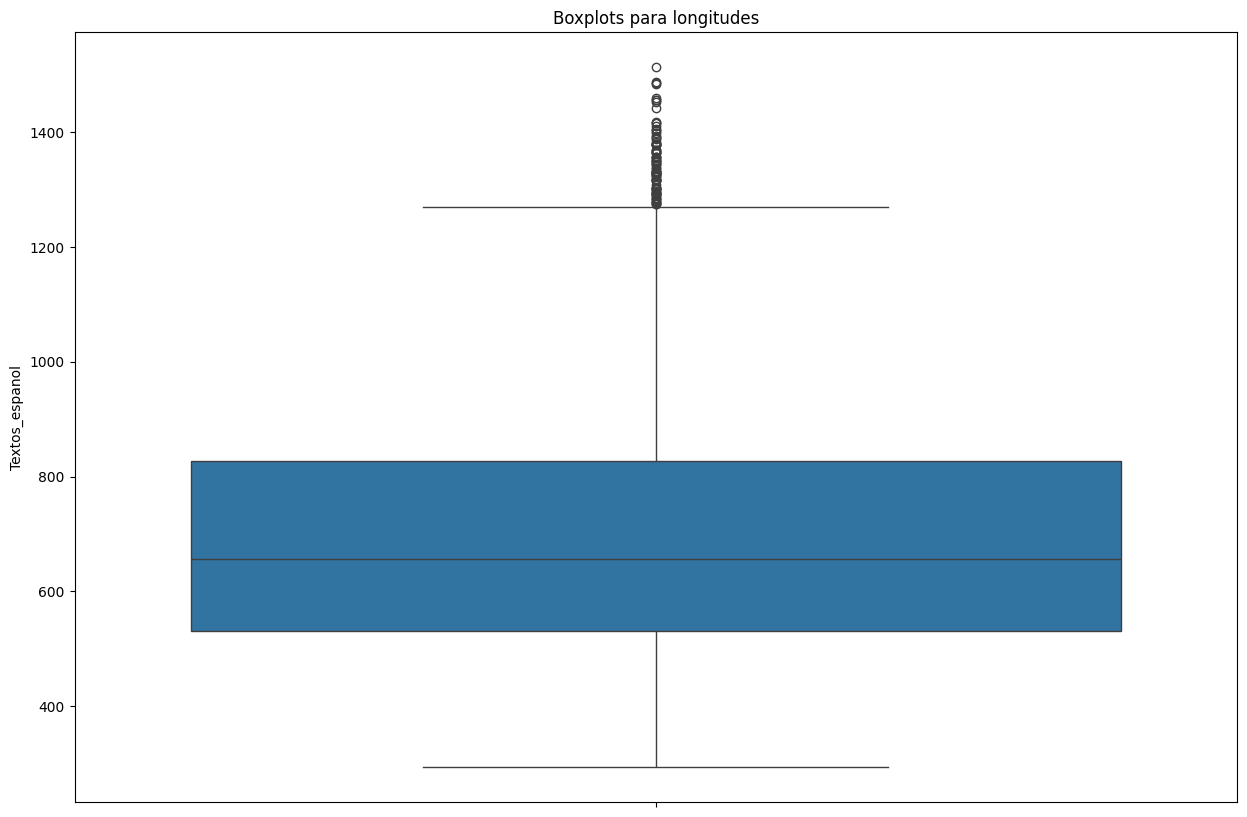

In [228]:
plt.figure(figsize=(15,10))
sns.boxplot(data=longitudes)
plt.title('Boxplots para longitudes')
plt.show()

Hay longitudes atipicas 

In [229]:
longitudes.describe()

count    4049.000000
mean      699.632502
std       228.988965
min       294.000000
25%       531.000000
50%       657.000000
75%       827.000000
max      1513.000000
Name: Textos_espanol, dtype: float64

La longitud mas corta es de 294 caracteres. La mas larga es de 1513. El promedio es de 700 caracteres

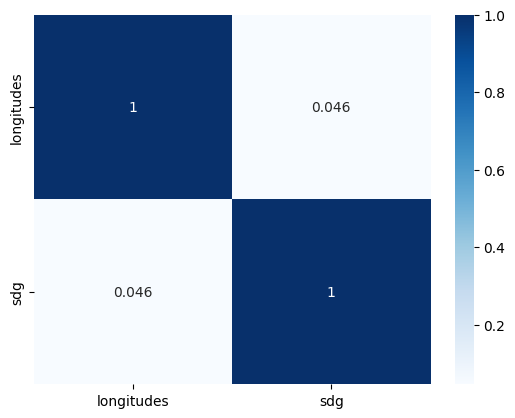

In [230]:
box_p = pd.DataFrame({'longitudes': longitudes, 'sdg': r_ods['sdg']}).corr()
sns.heatmap(box_p, cmap="Blues", annot=True)
plt.show()

Como se observa, la clasificacion del sdg y la longitus no tienen correlacion

### 2.2 Calidad de datos

#### 2.2.1 Completitud

In [231]:
r_ods.notnull().mean()*100

Textos_espanol    100.0
sdg               100.0
dtype: float64

Las dos columnas estan completas

#### 2.2.2 Unicidad

In [232]:
r_ods.duplicated(keep = False).sum()

0

No hay registros repetidos

#### 2.2.3 Consistencia

In [233]:
r_ods.dtypes

Textos_espanol    object
sdg                int64
dtype: object

El texto es un string, y el ODS es numerico. Es consistente

#### 2.2.4 Validez

Anteriormente se vio que sgd solo toma valores entre 3 y 5, lo cual es valido en el contexto que se trabaja

### 2.3 Preparación de datos

In [234]:
registros = r_ods.copy()

Se usara una funcion auxiliar para hacer la preparacion. Se va a pasar a minuscula el texto, y se eliminaran las palabras comunes del idioma español.
No se detectaron problemas en la calidad de los datos. Estan completos, son unicos, son consistentes y válidos

In [235]:
nltk.download('stopwords')

comunes = set(stopwords.words('spanish'))

def limpiar_texto(texto):
    texto = texto.lower()
    texto = re.sub(f'[{string.punctuation}]', '', texto)
    palabras = texto.split()
    palabras_limpias = [palabra for palabra in palabras if palabra not in comunes]
    return ' '.join(palabras_limpias)

registros['Textos_espanol_limpio'] = registros['Textos_espanol'].apply(limpiar_texto)
registros[['Textos_espanol', 'Textos_espanol_limpio']].head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\57313\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Textos_espanol,Textos_espanol_limpio
0,"Por ejemplo, el nÃºmero de consultas externas ...",ejemplo nãºmero consultas externas especialist...
1,"En 2007, el gobierno central financió directam...",2007 gobierno central financió directamente so...
2,"Claramente, hay muchos otros factores en juego...",claramente factores juego particular variedad ...
3,"Por ejemplo, el estado australiano de Victoria...",ejemplo australiano victoria creó agencia prom...
4,"El consumo anual de alcohol se estima en 15,7 ...",consumo anual alcohol estima 157 litros año ho...


## Sección 3 - Modelado y evaluación

In [236]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(registros['Textos_espanol_limpio'])

In [237]:
Y = registros['sdg']

In [238]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

### Modelo 1: Decision Tree Classifier

Este modelo divide el espacio de datos en subconjutos, con nodos de un arbol. Cada nodo del arbol es una caracteristica de entrada. Cada rama representa una valor de una caracteristica. Se decidió intentar un modelo de este tipo porque es facil de implementar.

In [239]:
particiones = KFold(n_splits=10, shuffle=True, random_state = 0)
param_grid = {'criterion':['gini', 'entropy'],'max_depth':[4,6,8,10,20]}
arbol = DecisionTreeClassifier(random_state=0)

In [240]:
mejor_modelo = GridSearchCV(arbol, param_grid, cv=particiones)
# Ajuste del modelo
mejor_modelo.fit(X_train, Y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=0, shuffle=True),
             estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 6, 8, 10, 20]})

In [241]:
mejor_modelo.best_params_

{'criterion': 'entropy', 'max_depth': 20}

In [242]:
arbol = mejor_modelo.best_estimator_

In [243]:
y_pred = arbol.predict(X_test)

#### Métricas de evaluación

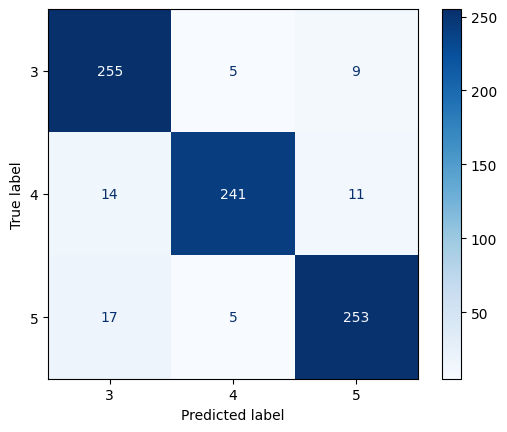

In [244]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(Y_test, y_pred), display_labels=arbol.classes_)
disp.plot(cmap=plt.cm.Blues)

plt.show()

In [245]:
print('Exactitud: %.2f' % accuracy_score(Y_test, y_pred))
print("Recall: {}".format(recall_score(Y_test,y_pred,average='macro')))
print("Precisión: {}".format(precision_score(Y_test,y_pred,average='macro')))
print("Puntuación F1: {}".format(f1_score(Y_test,y_pred,average='macro')))

Exactitud: 0.92
Recall: 0.9246568093095191
Precisión: 0.9261692269660399
Puntuación F1: 0.9248594413216248


In [246]:
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           3       0.89      0.95      0.92       269
           4       0.96      0.91      0.93       266
           5       0.93      0.92      0.92       275

    accuracy                           0.92       810
   macro avg       0.93      0.92      0.92       810
weighted avg       0.93      0.92      0.92       810



### Modelo 2: Random Forest Classifier

Este algoritmo construye varios arboles y combina resultados para mejorar la precisión. Tiene mayor precision que los arboles de decisión. Sin embargo, consume mas recursos ya que se entrenan multiples arboles.

Se decidió intentar este algoritmo ya que el reporte que se obtuvo del arbol de decisión aun podia mejorar

In [247]:
arbol_2 = RandomForestClassifier(n_estimators=100, max_depth=20, criterion = 'entropy' )

In [248]:
arbol_2.fit(X_train, Y_train)

RandomForestClassifier(criterion='entropy', max_depth=20)

In [249]:
y_pred_2 = arbol_2.predict(X_test)

#### Métricas de evaluación

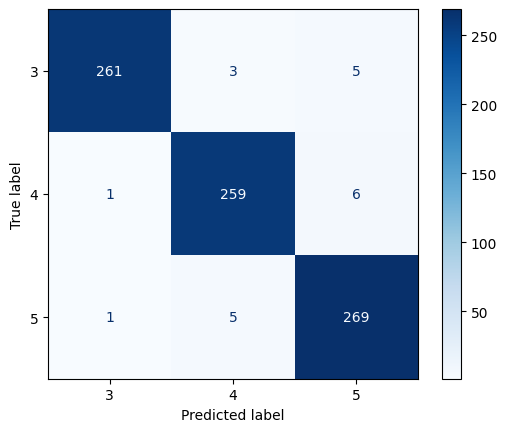

In [250]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(Y_test, y_pred_2), display_labels=arbol_2.classes_)
disp.plot(cmap=plt.cm.Blues)

plt.show()

In [251]:
print('Exactitud: %.2f' % accuracy_score(Y_test, y_pred_2))
print("Recall: {}".format(recall_score(Y_test,y_pred_2,average='macro')))
print("Precisión: {}".format(precision_score(Y_test,y_pred_2,average='macro')))
print("Puntuación F1: {}".format(f1_score(Y_test,y_pred_2,average='macro')))

Exactitud: 0.97
Recall: 0.9740420839188203
Precisión: 0.974382392053388
Puntuación F1: 0.9741432625899892


In [252]:
print(classification_report(Y_test, y_pred_2))

              precision    recall  f1-score   support

           3       0.99      0.97      0.98       269
           4       0.97      0.97      0.97       266
           5       0.96      0.98      0.97       275

    accuracy                           0.97       810
   macro avg       0.97      0.97      0.97       810
weighted avg       0.97      0.97      0.97       810



### Modelo 3: KNN

K-Nearest Neighbors se basa en la proximidad. Para hacer una predección, se evalua la proximidad a los vecinos y se asigna la clase mas cercana.
Este es facil de implementar. Se decidio usar un grid para intentar maximizar sus metricas, ya que con el algortimo anterior se tienen buenas metricas.
Aunque, esto va a hacerlo costoso computacionalmente, ademas que knn ya es costoso de por si

In [253]:
param_grid_knn = {
    'n_neighbors': [3, 5, 11, 19],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}
knn = KNeighborsClassifier()
grid_knn = GridSearchCV(estimator=knn, param_grid=param_grid_knn, cv=particiones)
grid_knn.fit(X_train, Y_train)


GridSearchCV(cv=KFold(n_splits=10, random_state=0, shuffle=True),
             estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [3, 5, 11, 19],
                         'weights': ['uniform', 'distance']})

In [254]:
grid_knn.best_params_

{'metric': 'euclidean', 'n_neighbors': 19, 'weights': 'uniform'}

In [255]:
knn = grid_knn.best_estimator_

In [256]:
y_pred_3 = knn.predict(X_test)

#### Métricas de evaluación

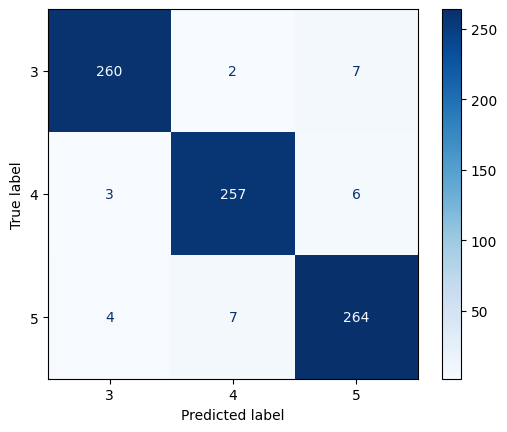

In [257]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(Y_test, y_pred_3), display_labels=knn.classes_)
disp.plot(cmap=plt.cm.Blues)

plt.show()

In [258]:
print('Exactitud: %.2f' % accuracy_score(Y_test, y_pred_3))
print("Recall: {}".format(recall_score(Y_test,y_pred_3,average='macro')))
print("Precisión: {}".format(precision_score(Y_test,y_pred_3,average='macro')))
print("Puntuación F1: {}".format(f1_score(Y_test,y_pred_3,average='macro')))

Exactitud: 0.96
Recall: 0.9642360548210674
Precisión: 0.964338925709059
Puntuación F1: 0.9642788021318708


In [259]:
print(classification_report(Y_test, y_pred_3))

              precision    recall  f1-score   support

           3       0.97      0.97      0.97       269
           4       0.97      0.97      0.97       266
           5       0.95      0.96      0.96       275

    accuracy                           0.96       810
   macro avg       0.96      0.96      0.96       810
weighted avg       0.96      0.96      0.96       810



## Sección 4 - Resultados


| Modelo                     | Exactitud | Recall  | Precisión | F1-Score  |
|----------------------------|-----------|---------|-----------|-----------|
| Decision Tree Classifier    | 0.92      | 0.92    | 0.93      | 0.92      |
| Random Forest Classifier    | 0.96      | 0.96    | 0.96      | 0.96      |
| KNN                        | 0.96      | 0.96    | 0.96      | 0.96      |


Se observa que random tree y KNN ofrecen las mejores metricas, por lo tanto, se descarta decision tree

Ahora, para elegir entre random y knn veremos el reporte

Viendo los resultados, se ve que en random 3 tiene metricas altas respecto a 5, mientras que en knn son mas parecidas. Aunque al final en el promedio ponderado sean iguales, no son iguales individualmente.
KNN nos ofrece metricas mas equilibradas, por lo que se escoge este. 
Es decir, knn tiene buen rendimiento para los tres ODS, mientras que random es muy bueno en ODS 3 y falla un poco en ODS 5

### Palabras clave

Vamos a ver las palabras que mas se repiten en cada ods

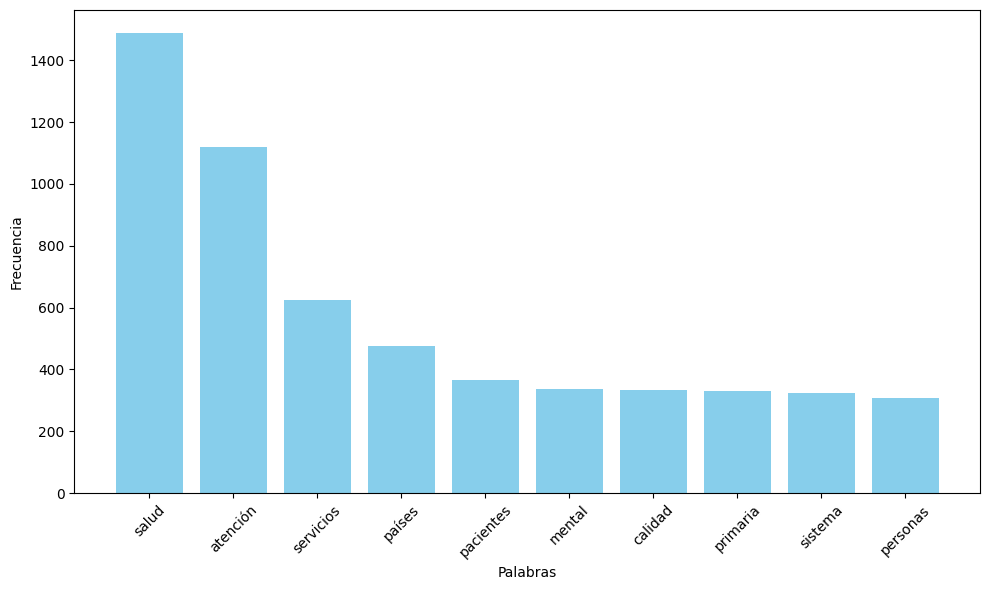

Palabras más comunes en SDG 3 salud 


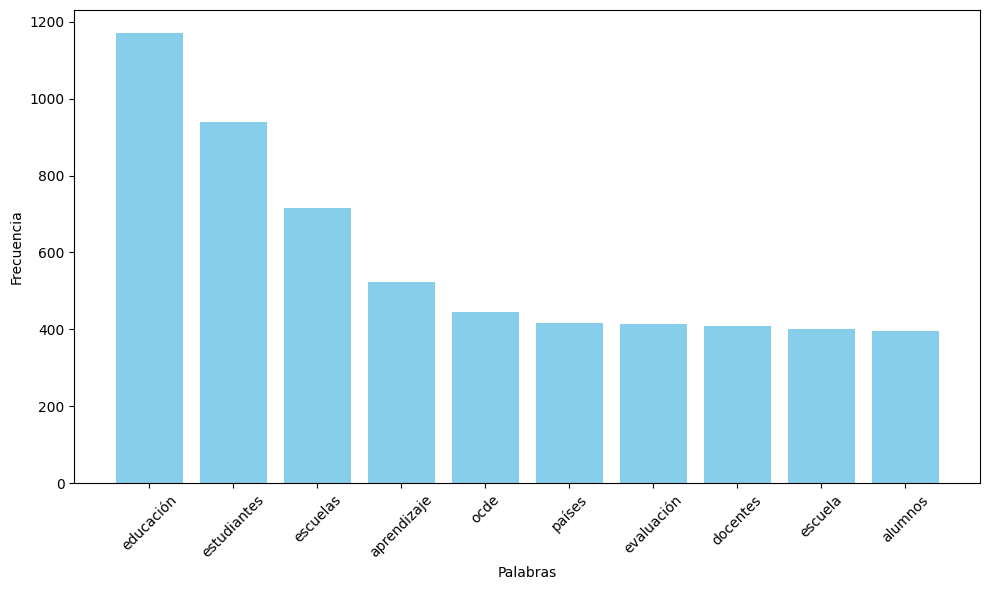

Palabras más comunes en SDG 4 educacion 


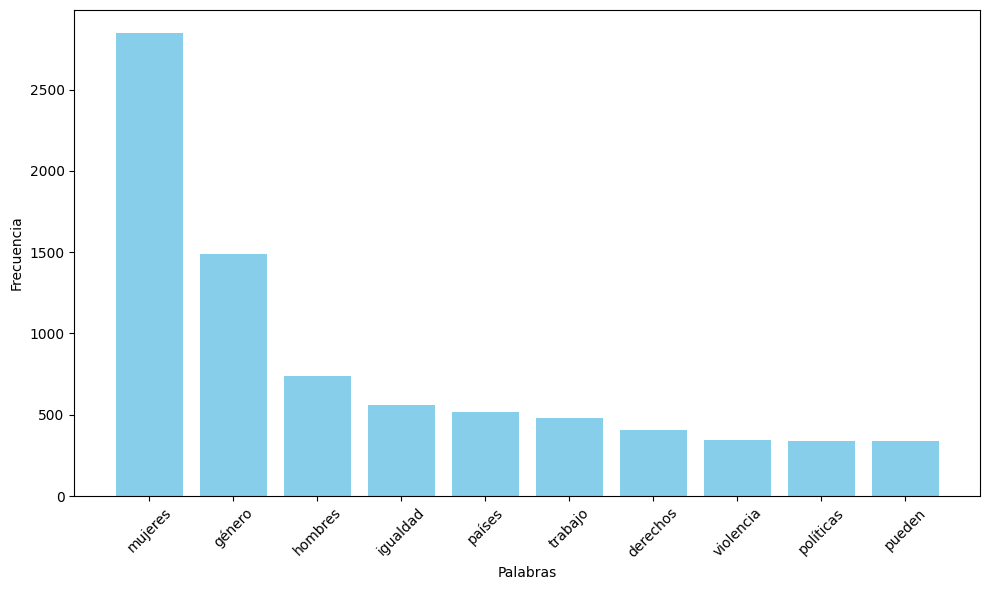

Palabras más comunes en SDG 5 igualdad de genero 


In [260]:
def mostrar_palabras_comunes(sdg_textos, n=10):
    # Vectorizar los textos
    vectorizer = CountVectorizer()  # Elimina stopwords en español
    X = vectorizer.fit_transform(sdg_textos)
    
    # Obtener las palabras y sus frecuencias
    sum_words = X.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    df = pd.DataFrame(words_freq[:n], columns=['Palabra', 'Frecuencia'])
    plt.figure(figsize=(10,6))
    plt.bar(df['Palabra'], df['Frecuencia'], color='skyblue')
    plt.xlabel('Palabras')
    plt.ylabel('Frecuencia')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    # Mostrar las palabras más comunes
    return ""

# Filtrar los registros por sdg
textos_sdg3 = registros[registros['sdg'] == 3]['Textos_espanol_limpio']
textos_sdg4 = registros[registros['sdg'] == 4]['Textos_espanol_limpio']
textos_sdg5 = registros[registros['sdg'] == 5]['Textos_espanol_limpio']

# Mostrar las 10 palabras más comunes para cada sdg
print("Palabras más comunes en SDG 3 salud", mostrar_palabras_comunes(textos_sdg3))
print("Palabras más comunes en SDG 4 educacion", mostrar_palabras_comunes(textos_sdg4))
print("Palabras más comunes en SDG 5 igualdad de genero", mostrar_palabras_comunes(textos_sdg5))

- ODS 3: Se evidencian palabras como salud y pacientes, que se relacionan con el ODS salud y bienestar
- ODS 4: Palabras como estudiantes, escuelas y docentes tienen una alta presencia en el ODS eduacion
- ODS 5: Mujeres, genero e igualdad se alinean con el ODS de igualdad de género

Paises: Se ve que esta palabra esta presente en los tres ODS con una frecuencia alta. Es probable que esta palabra deba pasar a ser una palabra comun para que no afecta al modelo de alguna manera. Aunque que la palabra este en plural nos indica cualitativamente que las opiniones pueden tener una vision global

### Prediccion en el archivo

Como se planteo anteriormente, se usara el modelo con KNN

In [261]:
prueba = pd.read_excel('./data/TestODScat_345.xlsx')
prueba_c = prueba.copy()

In [262]:
prueba_c['Textos_espanol_limpio'] = prueba_c['Textos_espanol'].apply(limpiar_texto)

In [263]:
X = vectorizer.transform(prueba_c['Textos_espanol_limpio'])
y_pred_f = knn.predict(X) # modelo knn definido en la seccion 3

In [264]:
prueba['sdg'] = y_pred_f
prueba.to_csv('./data/particion_prueba_estudiantes.csv', index=False)